In [1]:
%matplotlib inline
import numpy as np
from pandas import DataFrame, Series
from geostatsmodels import utilities, kriging, variograms, model, geoplot
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial.distance import pdist, squareform

In [2]:
from __init__ import *
from rain import *
from common import *

In [3]:
path = './input/'

rg = Rain(path=path, name='StLouis_MSD_gage_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rad = Rain(path=path, name='StLouis_MSD_radar_{YEAR}.csv', year=range(2009, 2015), ngages=101)
rg.ll_file = 'StLouis_MSD_lat_lon_{YEAR}.csv'.format(YEAR=rg.year)
rg.get_ll(cols=['lat','lon'])
rad.ll = rg.ll
p = RadarGage(gage=rg, radar=rad)
p.get_nonan()

In [4]:
rain_mean = rg.rate.mean()
rain_mean.name='rain_mean'

In [5]:
rg.get_rainiest(1)

In [6]:
cols = list(rg.rainiest.columns[0:-1])
cols.append('rainiest_day')

In [7]:
rg.rainiest.columns = cols

In [8]:
z = rg.rainiest

In [58]:
rg.rainiest.rainiest_day.min()

1.3440833333333331

In [9]:
z.X = z.X -z.X.min()
z.Y = z.Y -z.Y.min()

In [10]:
z = z[z.rainiest_day.notnull()]

In [11]:
rg.get_rainiest(1, time_step='1H', base=0)
cols = list(rg.rainiest.columns[0:-1])
cols.append('rainiest_hour')
rg.rainiest.columns = cols

In [12]:
z = z.join(rg.rainiest.rainiest_hour)

In [13]:
P = np.array(z[['X','Y','rainiest_hour']])

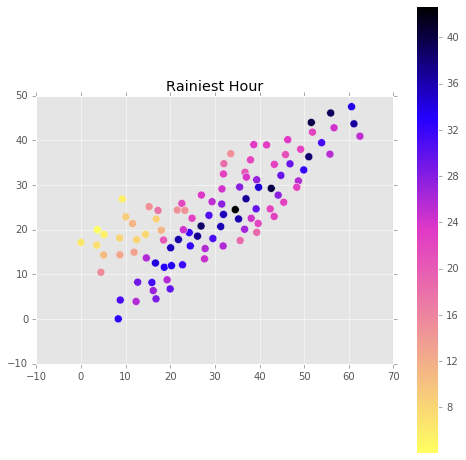

In [14]:
fig, ax = plt.subplots()
fig.set_size_inches(8,8)
cmap = geoplot.YPcmap
scat = ax.scatter( z.X, z.Y, c=z.rainiest_hour, s=64,cmap=cmap)
ax.set_aspect(1)
plt.colorbar(scat)

th=plt.title('Rainiest Hour')

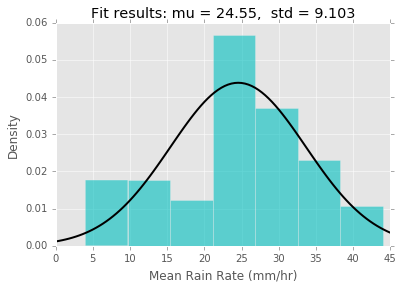

In [15]:
hrange = (4,44)
mu, std = norm.fit(z.rainiest_hour)
ahist=plt.hist(z.rainiest_hour, bins=7, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.3f" % (mu, std)
th=plt.title(title)
xh=plt.xlabel('Mean Rain Rate (mm/hr)')
yh=plt.ylabel('Density')

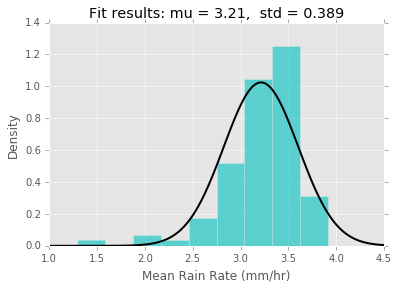

In [16]:
hrange = (1.3,4.2)
mu, std = norm.fit(z.rainiest_day)
ahist=plt.hist(z.rainiest_day, bins=10, normed=True, alpha=0.6, color='c',range=hrange)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.3f" % (mu, std)
th=plt.title(title)
xh=plt.xlabel('Mean Rain Rate (mm/hr)')
yh=plt.ylabel('Density')

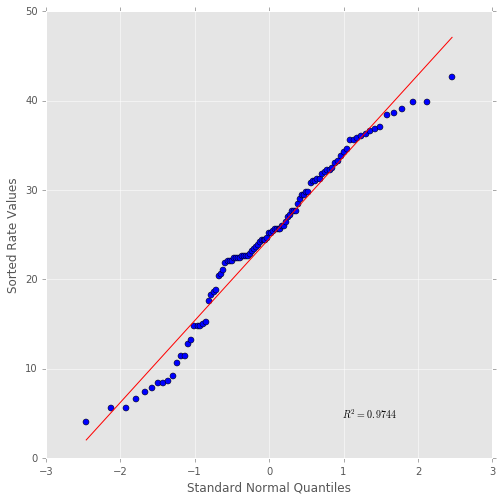

In [17]:
import scipy.stats as stats
qqdata = stats.probplot(z.rainiest_hour, dist="norm",plot=plt,fit=False)
xh=plt.xlabel('Standard Normal Quantiles')
yh=plt.ylabel('Sorted Rate Values')
fig=plt.gcf()
fig.set_size_inches(8,8)
th=plt.title('')

In [18]:
sill = np.var(P[:,2])
sill

82.867810211202922

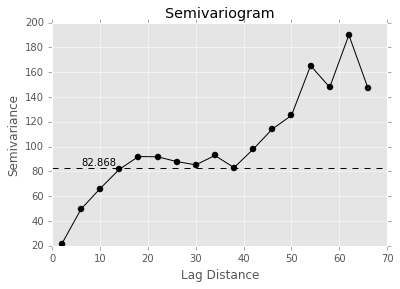

In [19]:
tolerance = 2
lags = np.arange( tolerance, 70, tolerance*2 )

geoplot.semivariogram( P, lags, tolerance )

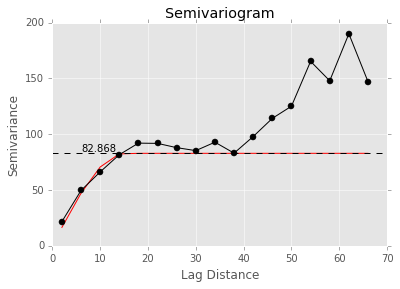

In [20]:
svm = model.semivariance(model.spherical, [15, sill])
geoplot.semivariogram( P, lags, tolerance, model=svm )

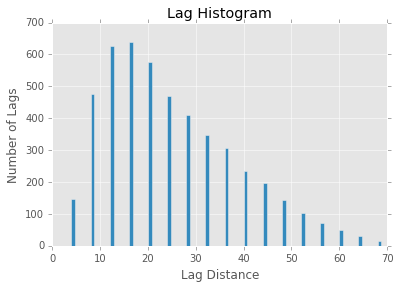

In [21]:
pw = utilities.pairwise(P)
geoplot.laghistogram( P, pw, lags, tolerance )

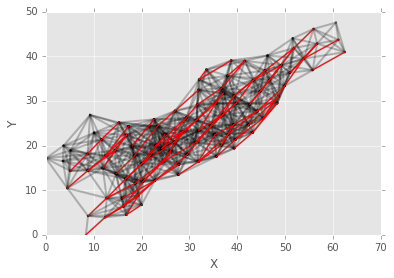

In [22]:
geoplot.anisotropiclags( P, pw, lag=1, tol=8, angle=39, atol=10)

In [ ]:
geoplot.anisotropiclags( P, pw, lag=1, tol=1, angle=39, atol=10)

In [23]:
covfct = model.covariance( model.spherical, ( 15, sill ) )

In [76]:
grid = [[x,y] for x in range(0,70,5) for y in range(0,50,5)]

In [77]:
x = [pt[0] for pt in grid]
y = [pt[1] for pt in grid]
k = kriging.krige(P, covfct, grid, method='simple', N=2)

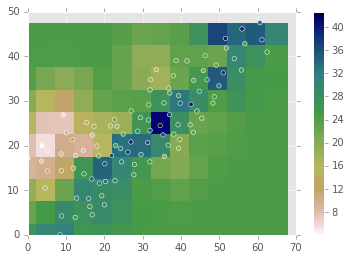

In [89]:
grid = [[x,y] for x in range(0,70,5) for y in range(0,50,5)]

x = [pt[0] for pt in grid]
y = [pt[1] for pt in grid]
k = kriging.krige(P, covfct, grid, method='simple', N=2)

fig, ax = plt.subplots()
vmin = P[:,2].min()
vmax = P[:,2].max()
ax.scatter(x, y, c=k[0], cmap='gist_earth_r', marker='s', edgecolors='none', s=500, vmin=vmin, vmax=vmax)
scat = ax.scatter(z.X, z.Y, c=z.rainiest_hour, cmap='gist_earth_r', edgecolors='1', vmin=vmin, vmax=vmax)
ax.set_xlim(0,70)
ax.set_ylim(0,50)
plt.colorbar(scat)
plt.show()